In [1]:
import numpy as np
import h5py
import sys
sys.path.append('/Users/eframe/repos/dmi/src')
import calibrate as calib
import eventAnalysis as ea
import tables
import matplotlib.pyplot as plt
import codedAperture as ca
import glob
import tables
from scipy import ndimage
import more_itertools as mit
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties

In [2]:
def gauss(x, h, mu, sig):
    """ Gaussian function
    """
    return h*np.exp(-0.5*((x-mu)/sig)**2)

In [60]:
# Loading Image Data
%matplotlib inline
f = tables.open_file('/Users/eframe/dmi/reconstructions/micro_comp/micro_comp_tik_TV.h5', 'r')
# f = tables.open_file('/Users/eframe/Downloads/micro_tik_TV_2.5e3_100.h5', 'r')
src = f.root.image.read()
f.close()

In [49]:
m = 2
wd = 2
wm = 2
res = 1 / ( m - 1 ) * np.sqrt( ( m * wm ) ** 2 + wd ** 2 )
sig = res / 2.355
print(res, sig)

4.47213595499958 1.8989961592354903


In [61]:
# Reshaping Image Data into 3D Image
binSize = 1
sourceX, sourceY, sourceZ = np.mgrid[ -19:21:binSize, -19:21:binSize, -19:21:binSize ]
vals = ( src.reshape( sourceX.shape ) / max(src) )
vals.shape

(40, 40, 40)

0


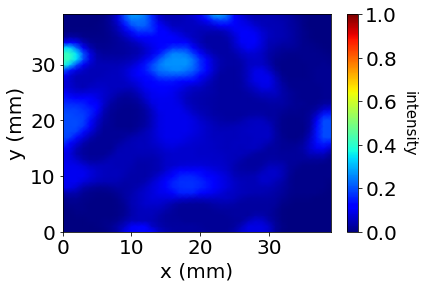

1


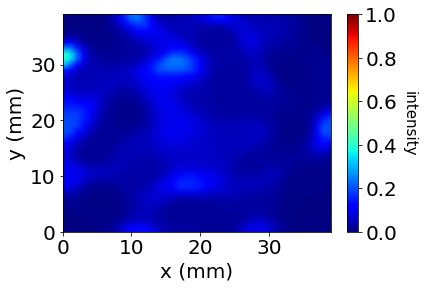

2


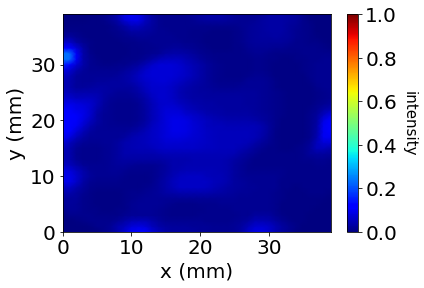

3


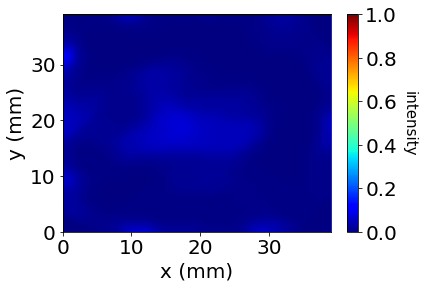

4


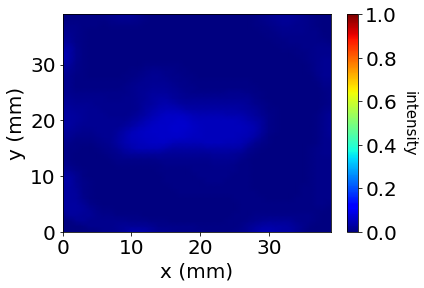

5


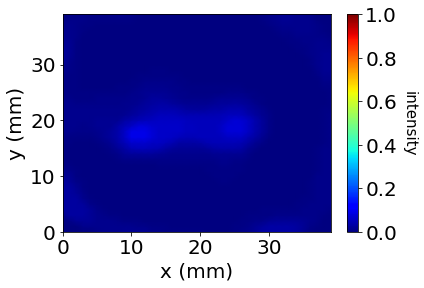

6


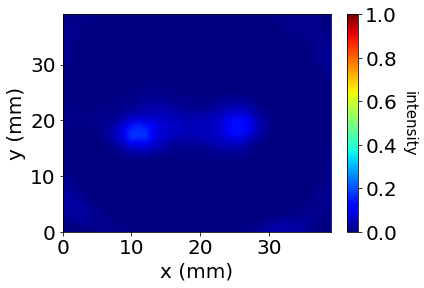

7


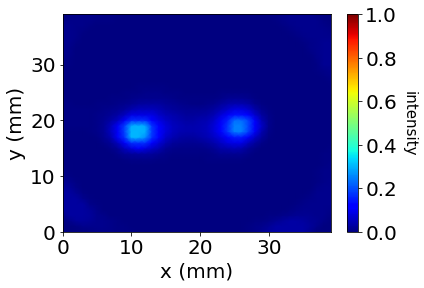

8


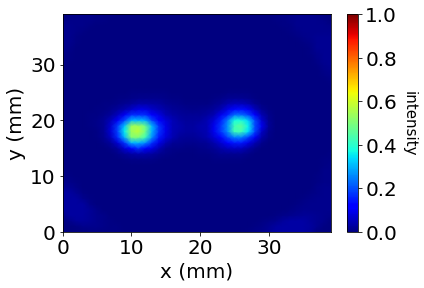

9


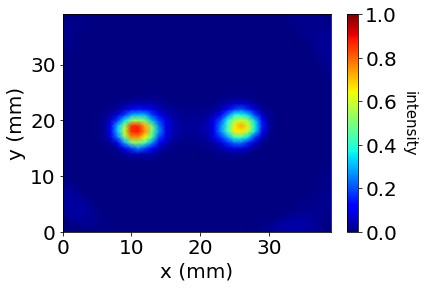

10


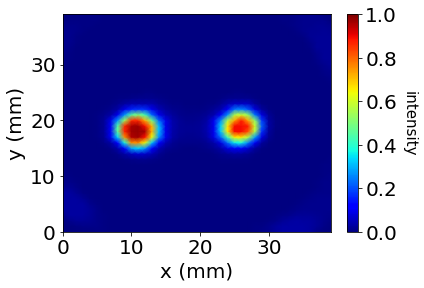

11


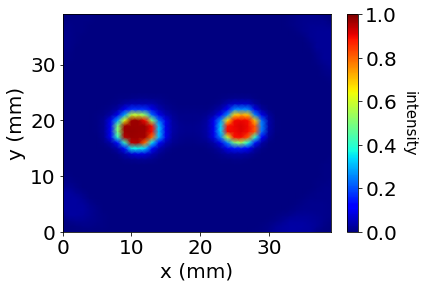

12


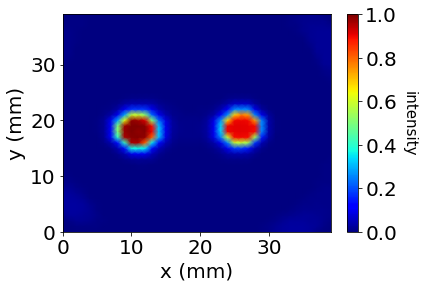

13


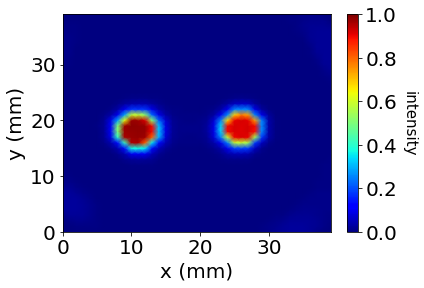

14


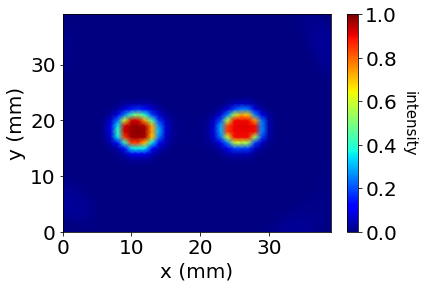

15


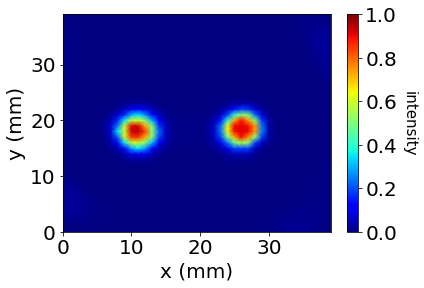

16


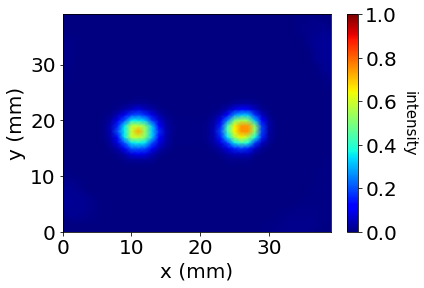

17


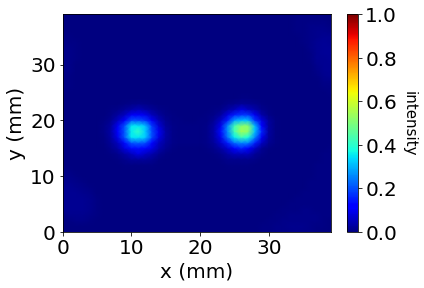

18


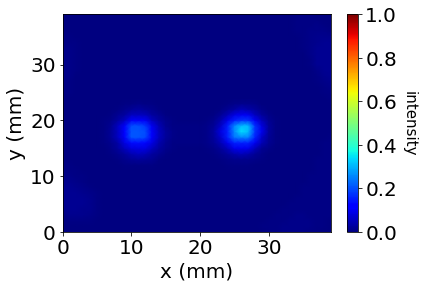

19


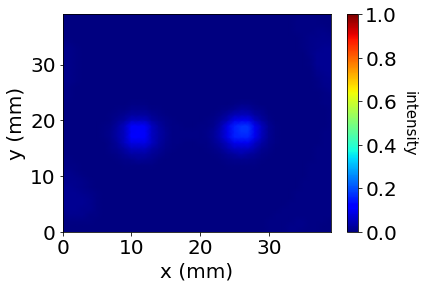

20


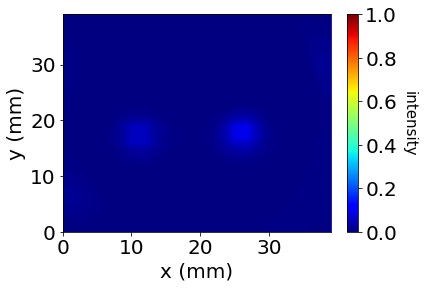

21


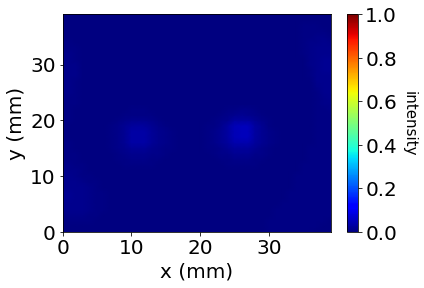

22


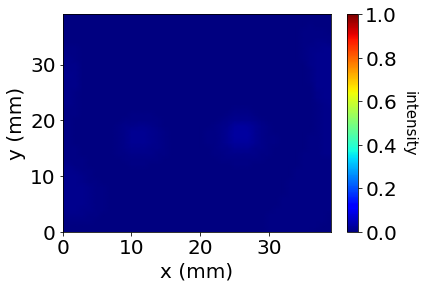

23


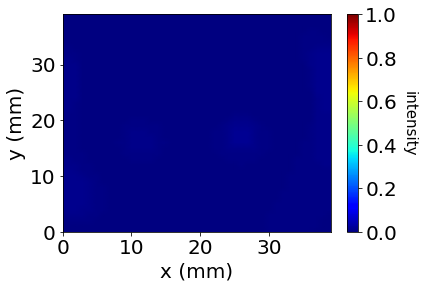

24


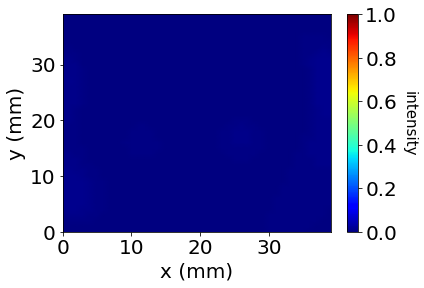

25


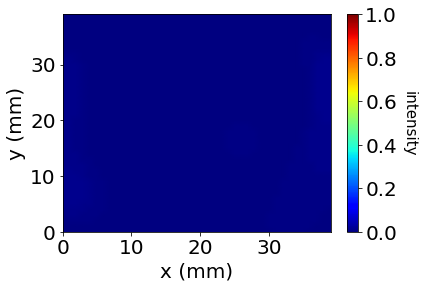

26


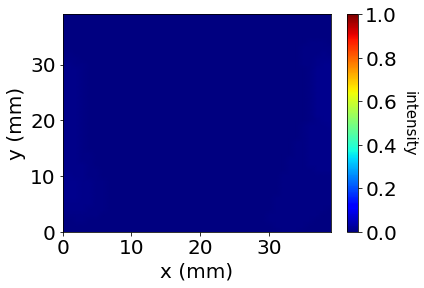

27


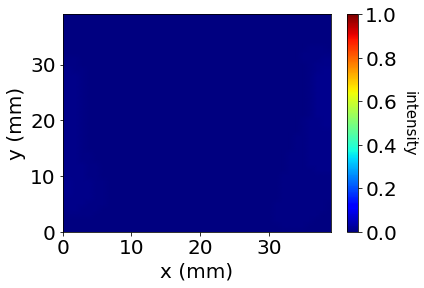

28


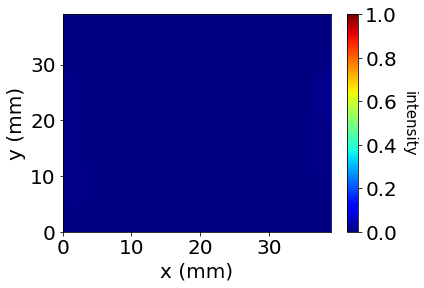

29


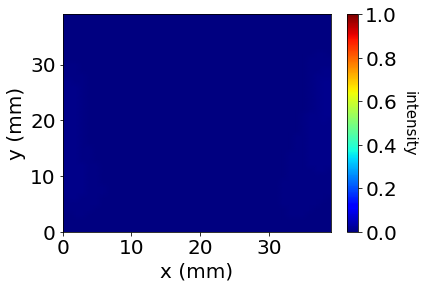

30


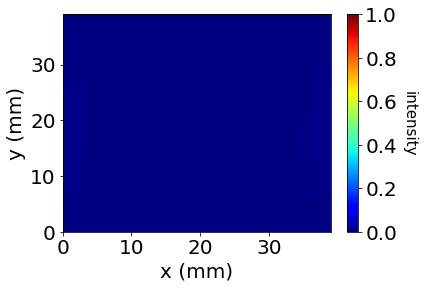

31


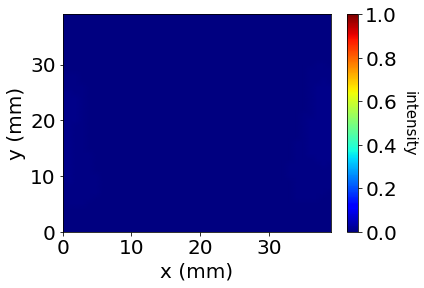

32


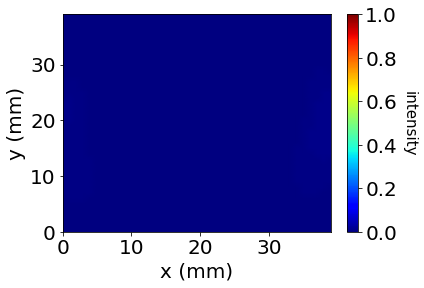

33


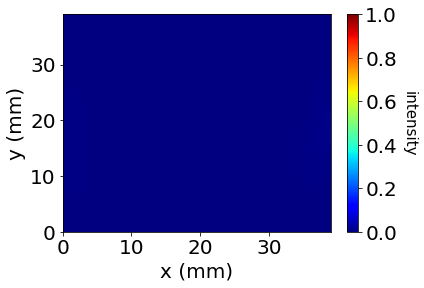

34


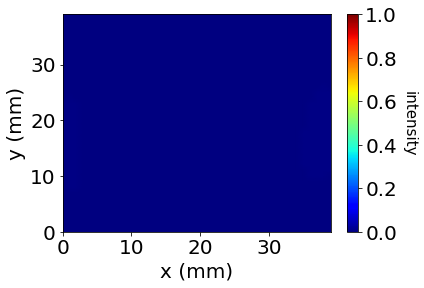

35


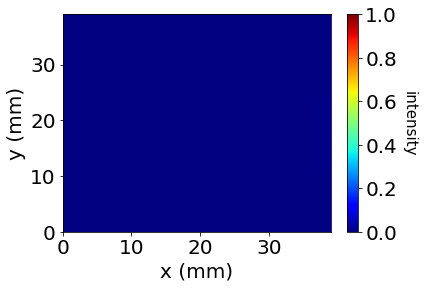

36


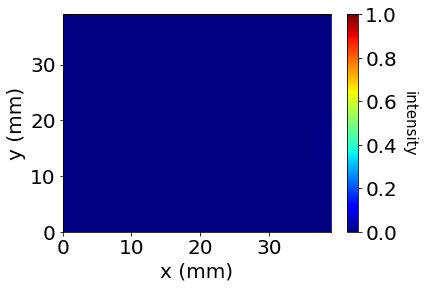

37


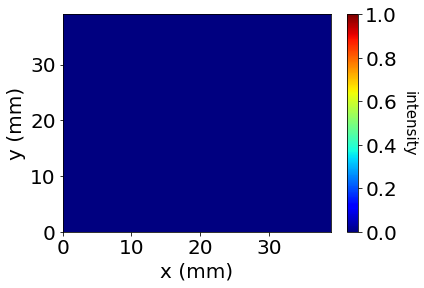

38


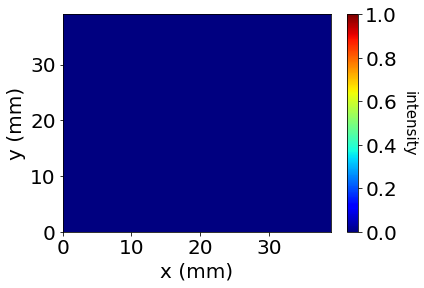

39


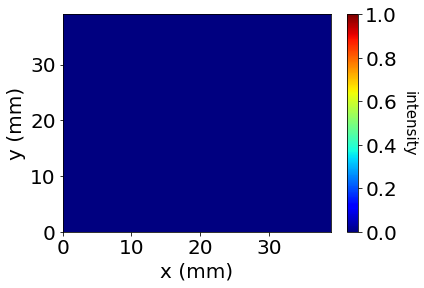

In [62]:
%matplotlib inline
depth = np.array( sourceZ[:,0][0] )
a, b = min(vals.flatten()), max(vals.flatten())
for i in np.arange( len(depth) ):
    fig, ax = plt.subplots()
    grid = vals[ :, :, i] 
    im = ax.pcolormesh( grid.T, vmin=a, vmax=b, cmap='jet', shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'y (mm)', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    print(i)
    plt.show()

In [52]:
vals[17,:,13].argmax()

20

13


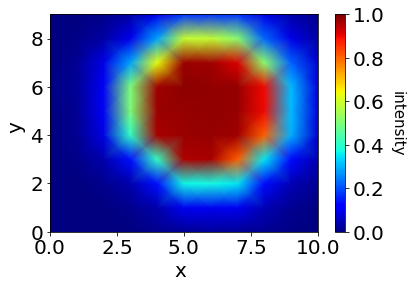

13


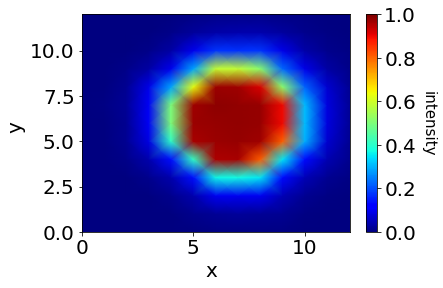

In [81]:
# Plotting 2D projections of Image
%matplotlib inline
x_max, y_max, zmax =  10, 18, 12
radius1 = 5
radius2 = 6

depth = np.array( sourceZ[:,0][0] )
a, b = min(vals.flatten()), max(vals.flatten())
for i in np.arange( 13, 14 ):
    fig, ax = plt.subplots()
    grid = vals[ :, :, i] 
    grid_r1 = grid[int(x_max-radius1):int(x_max+radius1+1), int(y_max-radius1):int(y_max+radius1) ]
    im = ax.pcolormesh( grid_r1.T, vmin=a, vmax=b, cmap='jet', shading = 'gouraud' ) 
    ax.set_xlabel( 'x ', fontsize = 20 )
    ax.set_ylabel( 'y ', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    print(i)
    plt.show()
    
for i in np.arange( 13, 14 ):
    fig, ax = plt.subplots()
    grid = vals[ :, :, i] 
    grid_r2 = grid[int(x_max-radius2):int(x_max+radius2+1), int(y_max-radius2):int(y_max+radius2+1) ]
    im = ax.pcolormesh( grid_r2.T, vmin=a, vmax=b, cmap='jet', shading = 'gouraud' ) 
    ax.set_xlabel( 'x ', fontsize = 20 )
    ax.set_ylabel( 'y ', fontsize = 20 )
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    print(i)
    plt.show()

In [75]:
x_center, y_center, zcenter = 0, 0, 0
M01 = 0
gridsum = 0
for i in np.arange( grid.shape[0] ):
    for j in np.arange( grid.shape[1] ):
        if ( i >= ( x_max - radius1 ) ) & ( i <= x_max + radius1 ) & \
        ( j >= ( y_max - radius1 ) ) & ( j <= y_max + radius1 ):
            x_center = grid[i][j] * i  + x_center
            y_center = grid[i][j] * j  + y_center
            M01 = M01 + grid[i][j]
x_mean1 = x_center / M01
y_mean1 = y_center / M01

x_center, y_center = 0, 0
M02 = 0
gridsum = 0
for i in np.arange( grid.shape[0] ):
    for j in np.arange( grid.shape[1] ):
        if ( i >= ( x_max - radius2 ) ) & ( i <= x_max + radius2 ) & \
        ( j >= ( y_max - radius2 ) ) & ( j <= y_max + radius2 ):
            x_center = grid[i][j] * i  + x_center
            y_center = grid[i][j] * j  + y_center
            M02 = M02 + grid[i][j]
x_mean2 = x_center / M02
y_mean2 = y_center / M02


M1x, M1y = 0, 0
for i in np.arange( grid.shape[0] ):
    for j in np.arange( grid.shape[1] ):
        if ( i >= ( x_max - radius1 ) ) & ( i <= x_max + radius1 ) & \
        ( j >= ( y_max - radius1 ) ) & ( j <= y_max + radius1 ):
            M1x = M1x + ( grid[i, j] * ( np.abs( x_mean1 - i ) ) ** 2  )
            M1y = M1y + ( grid[i, j] * ( np.abs( y_mean1 - j ) ) ** 2  )
            
M2x, M2y = 0, 0            
for i in np.arange( grid.shape[0] ):
    for j in np.arange( grid.shape[1] ):
        if ( i >= ( x_max - radius2 ) ) & ( i <= x_max + radius2 ) & \
        ( j >= ( y_max - radius2 ) ) & ( j <= y_max + radius2 ):
            M2x = M2x + ( grid[i, j] * ( np.abs( x_mean2 - i ) ) ** 2  )
            M2y = M2y + ( grid[i, j] * ( np.abs( y_mean2 - j ) ) ** 2  )

In [76]:
print( x_mean1, y_mean1 )
print( x_mean2, y_mean2 )

10.878494872781497 18.221561608430754
10.897997630384246 18.2263409984819


In [77]:
M1 = M1y.copy()
M2 = M2y.copy()
cov = ( radius2 ** 2 - radius1 ** 2) / ( radius2 ** 4 - radius1 ** 4 ) * \
( radius2 ** 4 * M1 ** 2 - radius1 ** 4 * M2 ** 2 ) / ( radius2 ** 2 * M01 - radius1 ** 2 * M02)

In [82]:
radius = 4.6 / 2 # mm
sd = np.sqrt( cov - ( 1 / 5 ) * radius ** 2 )
fwhm = np.sqrt(sd) * 2.355 * 1
print( fwhm )

10.200703447744662


In [79]:
np.sqrt(cov) 

18.79014348792844